In [1]:
 %load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt

from pltStyle import pltStyle
import os
# %matplotlib notebook 
# %matplotlib notebook 

### Import processor

In [4]:
from CoffeaJERCProcessor_L5 import Processor

Parameters of the run

In [5]:
UsingDaskExecutor = True
CoffeaCasaEnv     = False
load_preexisting  = False    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = False     ### True if run only on one file

tag = '_L5'

outname = 'out/CoffeaJERCOutputs'+tag+'.coffea'
outname = outname+'_test' if test_run else outname

In [6]:
## assume running on the LPC
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
# assume running on the lxplus
xrootdstr = 'root://cms-xrd-global.cern.ch//'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'

rootfiles = open('dataset.txt').read().split()

fileslist = [xrootdstr + file for file in rootfiles]

In [7]:
# to test on one file, uncomment the line below

fileslist = fileslist
if test_run:
    fileslist = [fileslist[0]]
    ### The smallest file in the RunIISummer20UL18NanoAODv9 dataset
    fileslist = ['root://cms-xrd-global.cern.ch//'+
                 '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']
# fileslist


### Test if certificate works (but this doesn't work on singularity :()

In [8]:
# fileslist2 = ['root://cms-xrd-global.cern.ch//'+
#                  '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']


In [9]:
# fileslist2

In [10]:
# import awkward as ak
# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# events = NanoEventsFactory.from_root(fileslist2[0], schemaclass=NanoAODSchema).events()

# events
# events.Generator.fields

# events.GenJet
# events.GenJet.fields
# events.GenJet.partonFlavour
# np.where((events.GenJet.hadronFlavour!=0).to_numpy)

# a = np.array([1,0,2,3,0])
# b = np.array([2,0,1,3,0])


In [11]:
# events.GenJet.fields

In [12]:
# arr = (events.GenJet.partonFlavour==5) | (events.GenJet.partonFlavour==-5)
# arra = np.array(arr.tolist())

In [13]:
# arra = np.array((events.GenJet.hadronFlavour!=0).tolist())

In [14]:
# fin = []
# for nn, li in enumerate(arra):
#     bla = np.where(li)
#     if len(bla[0])!=0:
#         fin.append([nn,bla])

In [15]:
# events.GenJet.hadronFlavour[18]

In [16]:
# fin

In [17]:
# len(arra)

In [18]:
# import ROOT as R

In [19]:
# R.TFile.Open(fileslist[0])

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [20]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [21]:
# Dask set up for LPC only 
if(UsingDaskExecutor and not CoffeaCasaEnv):
#     from lpcjobqueue import LPCCondorCluster
#     cluster = LPCCondorCluster()
#     cluster.adapt(minimum=1, maximum=10)
#     client = Client(cluster)
#     client.upload_file('CoffeaJERCProcessor.py')
    
    
    from dask.distributed import Client
#     client=Client()
#     cluster.adapt(minimum=1, maximum=10)
    client = Client()
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')
# client

2022-07-03 22:14:54,209 - distributed.diskutils - INFO - Found stale lock file and directory '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/dask-worker-space/worker-q_xy_1y1', purging
2022-07-03 22:14:54,324 - distributed.diskutils - INFO - Found stale lock file and directory '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/dask-worker-space/worker-3xljuysf', purging
2022-07-03 22:14:54,376 - distributed.diskutils - INFO - Found stale lock file and directory '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/dask-worker-space/worker-xofuc0cr', purging
2022-07-03 22:14:54,432 - distributed.diskutils - INFO - Found stale lock file and directory '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/dask-worker-space/worker-xmyl_1cz', purging
2022-07-03 22:14:54,471 - distributed.diskutils - INFO - Found stale lock file and directory '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/dask-worker-space/worker-kaoiqmjk', purging
2022-07-03 22:14:54,495 - distributed.diskutils - INFO - Found stale l

{'tcp://127.0.0.1:35063': {'status': 'OK'},
 'tcp://127.0.0.1:38675': {'status': 'OK'},
 'tcp://127.0.0.1:39018': {'status': 'OK'},
 'tcp://127.0.0.1:40445': {'status': 'OK'},
 'tcp://127.0.0.1:40781': {'status': 'OK'}}

In [22]:
# dataset_axis = hist.Cat("dataset", "Primary dataset")
# cats_axis = hist.Cat("anacat", "Analysis Category")

# jetpt_axis = hist.Bin("pt", r"$p_T$", ptbins)
# ptresponse_axis = hist.Bin("ptresponse", "RECO / GEN response", 100, 0, 5)
# jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
# jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", etabins)
# jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)

In [23]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

filesets = {'QCD': fileslist}

if not load_preexisting:
    for name,files in filesets.items(): 
        if not UsingDaskExecutor:
            chosen_exec = 'futures'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.iterative_executor,
        #                                        executor=processor.futures_executor,
                                              executor_args={
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
                                                  'workers': 2},
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])
        else:
            chosen_exec = 'dask'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.dask_executor,
                                              executor_args={
                                                  'client': client,
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
    #                                               'workers': 2
                                              },
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    util.save(output, outname)
    outputs_unweighted[name] = output
    print(name + ' unweighted output loaded')
else:
    # output = util.load('out/CoffeaJERCOutputs_binned.coffea')
    output = util.load(outname)
    
print("Output:")
print(output)
elapsed = time.time() - tstart

dict_keys(['Summer19UL18_V5_MC_L1FastJet_AK4PFchs', 'Summer19UL18_V5_MC_L2Relative_AK4PFchs'])
['Summer19UL18_V5_MC_L1FastJet_AK4PFchs', 'Summer19UL18_V5_MC_L2Relative_AK4PFchs']

[#################################       ] | 83% Completed |  1min  5.3s

2022-07-03 22:16:05,338 - distributed.worker - WARNING - Compute Failed
Key:       automatic_retries-43e07e50-1038-4ef0-b076-ea301da5e0e3-10
Function:  automatic_retries
args:      (<coffea.processor.executor.FileMeta object at 0x7fc51d40d680>)
kwargs:    {}
Exception: "OSError('XRootD error: [ERROR] Operation expired\\nin file root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/973E4D2A-7691-7546-AB55-43B6E8CFAE02.root')"



[##################################      ] | 85% Completed |  1min  9.3s

2022-07-03 22:16:09,308 - distributed.worker - WARNING - Compute Failed
Key:       automatic_retries-43e07e50-1038-4ef0-b076-ea301da5e0e3-26
Function:  automatic_retries
args:      (<coffea.processor.executor.FileMeta object at 0x7ff6ac81d380>)
kwargs:    {}
Exception: "OSError('XRootD error: [ERROR] Operation expired\\nin file root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/462DC780-F0A8-5843-8840-2211EF6C3439.root')"



[##################################      ] | 85% Completed |  1min 10.4s

2022-07-03 22:16:10,348 - distributed.worker - WARNING - Compute Failed
Key:       automatic_retries-43e07e50-1038-4ef0-b076-ea301da5e0e3-33
Function:  automatic_retries
args:      (<coffea.processor.executor.FileMeta object at 0x7efbe5229040>)
kwargs:    {}
Exception: "OSError('XRootD error: [ERROR] Operation expired\\nin file root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/7A50BCED-2D9A-7B4A-BE61-9D75DF5F187E.root')"



[#####################################   ] | 92% Completed |  1min 24.3s

2022-07-03 22:16:24,312 - distributed.worker - WARNING - Compute Failed
Key:       automatic_retries-43e07e50-1038-4ef0-b076-ea301da5e0e3-6
Function:  automatic_retries
args:      (<coffea.processor.executor.FileMeta object at 0x7ff68e3b09c0>)
kwargs:    {}
Exception: "OSError('XRootD error: [ERROR] Operation expired\\nin file root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/7DACCC77-5A3D-2B47-8704-FC25656DD5C8.root')"



[#                                       ] | 3% Completed |  1min 24.2s3s

2022-07-03 22:17:51,316 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#                                       ] | 3% Completed |  1min 26.5s

2022-07-03 22:17:53,638 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#                                       ] | 4% Completed |  1min 31.8s

2022-07-03 22:17:59,075 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#                                       ] | 4% Completed |  1min 34.4s

2022-07-03 22:18:01,586 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#                                       ] | 4% Completed |  1min 40.3s

2022-07-03 22:18:07,508 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#                                       ] | 4% Completed |  1min 43.1s

2022-07-03 22:18:10,325 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 5% Completed |  1min 48.8s

2022-07-03 22:18:16,015 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 5% Completed |  1min 50.5s

2022-07-03 22:18:17,723 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 5% Completed |  1min 56.6s

2022-07-03 22:18:23,725 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 5% Completed |  1min 57.9s

2022-07-03 22:18:25,048 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 5% Completed |  2min  3.9s

2022-07-03 22:18:31,117 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 5% Completed |  2min  5.5s

2022-07-03 22:18:32,632 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 11.9s

2022-07-03 22:18:39,089 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 13.3s

2022-07-03 22:18:40,532 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 17.4s

2022-07-03 22:18:44,533 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 18.6s

2022-07-03 22:18:45,767 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 19.6s

2022-07-03 22:18:46,767 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 22.0s

2022-07-03 22:18:49,231 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 23.0s

2022-07-03 22:18:50,122 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 24.6s

2022-07-03 22:18:51,878 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 27.1s

2022-07-03 22:18:54,292 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 28.3s

2022-07-03 22:18:55,502 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##                                      ] | 6% Completed |  2min 28.7s

2022-07-03 22:18:55,994 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 7% Completed |  2min 31.7s

2022-07-03 22:18:58,903 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##                                      ] | 7% Completed |  2min 33.4s

2022-07-03 22:19:00,638 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##                                      ] | 7% Completed |  2min 36.7s

2022-07-03 22:19:03,915 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##                                      ] | 7% Completed |  2min 38.5s

2022-07-03 22:19:05,762 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##                                      ] | 7% Completed |  2min 39.5s

2022-07-03 22:19:06,729 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###                                     ] | 7% Completed |  2min 42.3s

2022-07-03 22:19:09,471 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###                                     ] | 7% Completed |  2min 43.6s

2022-07-03 22:19:10,815 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-07-03 22:19:10,860 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###                                     ] | 7% Completed |  2min 45.3s

2022-07-03 22:19:12,551 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###                                     ] | 7% Completed |  2min 47.2s

2022-07-03 22:19:14,469 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###                                     ] | 7% Completed |  2min 49.5s

2022-07-03 22:19:16,708 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###                                     ] | 7% Completed |  2min 50.7s

2022-07-03 22:19:17,848 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###                                     ] | 7% Completed |  2min 51.5s

2022-07-03 22:19:18,704 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-07-03 22:19:18,755 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  2min 52.8s

2022-07-03 22:19:20,003 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  2min 55.8s

2022-07-03 22:19:22,948 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  2min 56.2s

2022-07-03 22:19:23,468 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-07-03 22:19:23,594 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  2min 58.7s

2022-07-03 22:19:25,951 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  0.6s

2022-07-03 22:19:27,824 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  1.0s

2022-07-03 22:19:28,208 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  1.2s

2022-07-03 22:19:28,433 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  2.1s

2022-07-03 22:19:29,309 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  6.0s

2022-07-03 22:19:33,124 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  6.7s

2022-07-03 22:19:33,827 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  6.9s

2022-07-03 22:19:34,094 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min  8.5s

2022-07-03 22:19:35,685 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min 11.1s

2022-07-03 22:19:38,367 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 22:19:38,505 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###                                     ] | 8% Completed |  3min 12.7s

2022-07-03 22:19:39,840 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 16.1s

2022-07-03 22:19:43,297 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-07-03 22:19:43,389 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 17.9s

2022-07-03 22:19:45,099 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 18.8s

2022-07-03 22:19:45,980 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 19.4s

2022-07-03 22:19:46,560 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 22.5s

2022-07-03 22:19:49,742 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-07-03 22:19:49,806 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 23.2s

2022-07-03 22:19:50,380 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 25.3s

2022-07-03 22:19:52,552 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 26.8s

2022-07-03 22:19:53,988 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 27.5s

2022-07-03 22:19:54,652 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 28.5s

2022-07-03 22:19:55,727 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 30.7s

2022-07-03 22:19:57,834 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 33.0s

2022-07-03 22:20:00,238 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 33.4s

2022-07-03 22:20:00,594 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 33.9s

2022-07-03 22:20:01,035 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 36.1s

2022-07-03 22:20:03,375 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 37.0s

2022-07-03 22:20:04,129 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###                                     ] | 9% Completed |  3min 38.9s

2022-07-03 22:20:06,180 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-03 22:20:06,265 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 40.9s

2022-07-03 22:20:08,053 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 44.1s

2022-07-03 22:20:11,306 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 45.0s

2022-07-03 22:20:12,105 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 46.2s

2022-07-03 22:20:13,348 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 47.4s

2022-07-03 22:20:14,587 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 48.7s

2022-07-03 22:20:15,878 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 51.8s

2022-07-03 22:20:19,017 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 52.9s

2022-07-03 22:20:20,163 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 54.8s

2022-07-03 22:20:22,044 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 56.8s

2022-07-03 22:20:23,959 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 58.7s

2022-07-03 22:20:25,914 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  3min 59.4s

2022-07-03 22:20:26,599 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  4min  2.8s

2022-07-03 22:20:29,986 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  4min  3.2s

2022-07-03 22:20:30,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  4min  4.7s

2022-07-03 22:20:31,855 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  4min  4.9s

2022-07-03 22:20:32,062 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####                                    ] | 10% Completed |  4min  5.5s

2022-07-03 22:20:32,750 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min  9.7s

2022-07-03 22:20:36,878 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 10.2s

2022-07-03 22:20:37,373 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 11.1s

2022-07-03 22:20:38,349 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 13.5s

2022-07-03 22:20:40,720 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 16.1s

2022-07-03 22:20:43,293 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 17.6s

2022-07-03 22:20:44,738 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 18.0s

2022-07-03 22:20:45,125 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 18.5s

2022-07-03 22:20:45,708 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 21.6s

2022-07-03 22:20:48,823 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 23.0s

2022-07-03 22:20:50,154 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-03 22:20:50,164 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 11% Completed |  4min 25.7s

2022-07-03 22:20:52,846 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 22:20:52,888 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[####                                    ] | 12% Completed |  4min 27.1s

2022-07-03 22:20:54,318 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[####                                    ] | 12% Completed |  4min 28.3s

2022-07-03 22:20:55,472 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 12% Completed |  4min 31.0s

2022-07-03 22:20:58,238 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 22:20:58,243 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[####                                    ] | 12% Completed |  4min 32.5s

2022-07-03 22:20:59,684 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[####                                    ] | 12% Completed |  4min 33.1s

2022-07-03 22:21:00,304 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[####                                    ] | 12% Completed |  4min 38.0s

2022-07-03 22:21:05,203 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[####                                    ] | 12% Completed |  4min 39.0s

2022-07-03 22:21:06,234 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####                                   ] | 12% Completed |  4min 40.7s

2022-07-03 22:21:07,899 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#####                                   ] | 12% Completed |  4min 41.3s

2022-07-03 22:21:08,565 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 12% Completed |  4min 44.1s

2022-07-03 22:21:11,337 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 12% Completed |  4min 45.1s

2022-07-03 22:21:12,320 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#####                                   ] | 12% Completed |  4min 47.1s

2022-07-03 22:21:14,335 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####                                   ] | 12% Completed |  4min 49.3s

2022-07-03 22:21:16,526 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  4min 51.2s

2022-07-03 22:21:18,477 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  4min 52.8s

2022-07-03 22:21:20,037 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  4min 53.3s

2022-07-03 22:21:20,550 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  4min 55.7s

2022-07-03 22:21:23,006 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-07-03 22:21:23,037 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  4min 57.8s

2022-07-03 22:21:25,069 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  4min 59.2s

2022-07-03 22:21:26,376 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min  0.7s

2022-07-03 22:21:27,903 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min  1.5s

2022-07-03 22:21:28,701 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min  4.3s

2022-07-03 22:21:31,465 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min  5.4s

2022-07-03 22:21:32,597 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min  8.8s

2022-07-03 22:21:36,027 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min  9.8s

2022-07-03 22:21:37,019 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min 12.0s

2022-07-03 22:21:39,225 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min 12.4s

2022-07-03 22:21:39,634 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min 13.0s

2022-07-03 22:21:40,182 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min 14.1s

2022-07-03 22:21:41,290 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#####                                   ] | 13% Completed |  5min 15.2s

2022-07-03 22:21:42,452 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 20.4s

2022-07-03 22:21:47,623 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 21.8s

2022-07-03 22:21:49,064 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 22.4s

2022-07-03 22:21:49,529 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-07-03 22:21:49,618 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 22.8s

2022-07-03 22:21:49,947 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 27.5s

2022-07-03 22:21:54,659 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 29.1s

2022-07-03 22:21:56,247 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 29.5s

2022-07-03 22:21:56,756 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 30.8s

2022-07-03 22:21:57,955 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 32.0s

2022-07-03 22:21:59,309 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 32.5s

2022-07-03 22:21:59,648 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 32.8s

2022-07-03 22:21:59,970 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#####                                   ] | 14% Completed |  5min 33.3s

2022-07-03 22:22:00,476 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 40.4s

2022-07-03 22:22:07,601 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 41.5s

2022-07-03 22:22:08,609 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-07-03 22:22:08,645 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-03 22:22:08,767 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 42.9s

2022-07-03 22:22:10,125 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 46.5s

2022-07-03 22:22:13,734 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 48.9s

2022-07-03 22:22:16,135 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-03 22:22:16,264 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 51.7s

2022-07-03 22:22:18,970 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-07-03 22:22:18,979 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-03 22:22:19,133 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 52.4s

2022-07-03 22:22:19,592 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 54.7s

2022-07-03 22:22:21,857 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  5min 58.7s

2022-07-03 22:22:26,005 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  6min  0.4s

2022-07-03 22:22:27,636 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  6min  1.5s

2022-07-03 22:22:28,691 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  6min  4.2s

2022-07-03 22:22:31,394 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 15% Completed |  6min  4.7s

2022-07-03 22:22:31,881 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min  5.2s

2022-07-03 22:22:32,325 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min  8.9s

2022-07-03 22:22:36,026 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 14.3s

2022-07-03 22:22:41,401 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 16.3s

2022-07-03 22:22:43,507 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 16.9s

2022-07-03 22:22:44,170 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 17.3s

2022-07-03 22:22:44,485 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 17.6s

2022-07-03 22:22:44,795 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 26.5s

2022-07-03 22:22:53,760 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 26.8s

2022-07-03 22:22:54,053 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 28.7s

2022-07-03 22:22:55,907 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 29.3s

2022-07-03 22:22:56,493 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 33.1s

2022-07-03 22:23:00,370 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[######                                  ] | 16% Completed |  6min 34.7s

2022-07-03 22:23:01,923 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[######                                  ] | 17% Completed |  6min 38.3s

2022-07-03 22:23:05,475 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######                                  ] | 17% Completed |  6min 41.5s

2022-07-03 22:23:08,684 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 17% Completed |  6min 42.9s

2022-07-03 22:23:10,089 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######                                  ] | 17% Completed |  6min 44.4s

2022-07-03 22:23:11,565 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[######                                  ] | 17% Completed |  6min 44.8s

2022-07-03 22:23:11,933 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[######                                  ] | 17% Completed |  6min 49.8s

2022-07-03 22:23:17,016 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 17% Completed |  6min 52.8s

2022-07-03 22:23:20,048 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 17% Completed |  6min 55.4s

2022-07-03 22:23:22,656 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-07-03 22:23:22,858 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 17% Completed |  6min 58.5s

2022-07-03 22:23:25,632 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 17% Completed |  6min 59.5s

2022-07-03 22:23:26,719 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#######                                 ] | 17% Completed |  6min 59.7s

2022-07-03 22:23:26,984 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 17% Completed |  7min  4.2s

2022-07-03 22:23:31,421 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 17% Completed |  7min  7.7s

2022-07-03 22:23:34,864 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min  9.5s

2022-07-03 22:23:36,793 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 11.7s

2022-07-03 22:23:38,900 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 11.8s

2022-07-03 22:23:39,133 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 15.8s

2022-07-03 22:23:43,053 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 16.8s

2022-07-03 22:23:43,975 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 17.7s

2022-07-03 22:23:44,905 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 22.3s

2022-07-03 22:23:49,413 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 22.6s

2022-07-03 22:23:49,777 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 25.2s

2022-07-03 22:23:52,476 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 26.2s

2022-07-03 22:23:53,405 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 30.1s

2022-07-03 22:23:57,365 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 33.5s

2022-07-03 22:24:00,665 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 35.8s

2022-07-03 22:24:03,078 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 37.5s

2022-07-03 22:24:04,697 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 18% Completed |  7min 38.9s

2022-07-03 22:24:06,116 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 41.3s

2022-07-03 22:24:08,533 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 42.2s

2022-07-03 22:24:09,314 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 45.4s

2022-07-03 22:24:12,671 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 49.0s

2022-07-03 22:24:16,139 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 49.3s

2022-07-03 22:24:16,497 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 51.9s

2022-07-03 22:24:19,217 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 53.6s

2022-07-03 22:24:20,765 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 55.3s

2022-07-03 22:24:22,471 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 56.2s

2022-07-03 22:24:23,352 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  7min 58.9s

2022-07-03 22:24:26,158 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  8min  1.2s

2022-07-03 22:24:28,357 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  8min  1.6s

2022-07-03 22:24:28,812 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  8min  4.0s

2022-07-03 22:24:31,182 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  8min  4.4s

2022-07-03 22:24:31,594 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#######                                 ] | 19% Completed |  8min  6.3s

2022-07-03 22:24:33,565 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min  8.1s

2022-07-03 22:24:35,278 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-03 22:24:35,376 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min  9.0s

2022-07-03 22:24:36,193 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 11.6s

2022-07-03 22:24:38,761 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 13.5s

2022-07-03 22:24:40,691 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 14.4s

2022-07-03 22:24:41,589 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 17.0s

2022-07-03 22:24:44,207 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 18.2s

2022-07-03 22:24:45,380 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 18.5s

2022-07-03 22:24:45,616 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 23.1s

2022-07-03 22:24:50,344 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 23.5s

2022-07-03 22:24:50,650 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 27.0s

2022-07-03 22:24:54,201 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 27.8s

2022-07-03 22:24:55,045 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 30.8s

2022-07-03 22:24:58,018 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 31.9s

2022-07-03 22:24:59,015 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 32.1s

2022-07-03 22:24:59,347 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 32.6s

2022-07-03 22:24:59,781 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 34.3s

2022-07-03 22:25:01,478 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[########                                ] | 20% Completed |  8min 35.5s

2022-07-03 22:25:02,728 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 40.0s

2022-07-03 22:25:07,219 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 41.4s

2022-07-03 22:25:08,601 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 41.8s

2022-07-03 22:25:08,948 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 43.4s

2022-07-03 22:25:10,568 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 44.5s

2022-07-03 22:25:11,737 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 45.8s

2022-07-03 22:25:12,960 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 47.3s

2022-07-03 22:25:14,520 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 49.0s

2022-07-03 22:25:16,170 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 51.6s

2022-07-03 22:25:18,802 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 51.9s

2022-07-03 22:25:19,123 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 54.0s

2022-07-03 22:25:21,214 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 54.7s

2022-07-03 22:25:21,858 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 21% Completed |  8min 55.1s

2022-07-03 22:25:22,266 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[########                                ] | 22% Completed |  8min 59.3s

2022-07-03 22:25:26,428 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[########                                ] | 22% Completed |  9min  0.4s

2022-07-03 22:25:27,632 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[########                                ] | 22% Completed |  9min  1.7s

2022-07-03 22:25:28,893 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-07-03 22:25:29,077 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########                                ] | 22% Completed |  9min  4.6s

2022-07-03 22:25:31,896 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[########                                ] | 22% Completed |  9min  5.2s

2022-07-03 22:25:32,490 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min  5.9s

2022-07-03 22:25:33,051 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min  7.5s

2022-07-03 22:25:34,608 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min  8.0s

2022-07-03 22:25:35,161 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min  8.9s

2022-07-03 22:25:36,008 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min 12.3s

2022-07-03 22:25:39,483 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min 13.7s

2022-07-03 22:25:40,881 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min 14.0s

2022-07-03 22:25:41,221 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#########                               ] | 22% Completed |  9min 16.1s

2022-07-03 22:25:43,336 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 16.6s

2022-07-03 22:25:43,731 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 18.8s

2022-07-03 22:25:46,032 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 19.5s

2022-07-03 22:25:46,726 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 23.0s

2022-07-03 22:25:50,273 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 24.4s

2022-07-03 22:25:51,549 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 26.4s

2022-07-03 22:25:53,617 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-07-03 22:25:53,710 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 31.6s

2022-07-03 22:25:58,784 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 32.0s

2022-07-03 22:25:59,144 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 32.8s

2022-07-03 22:25:59,910 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 34.1s

2022-07-03 22:26:01,343 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 35.8s

2022-07-03 22:26:02,991 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 37.1s

2022-07-03 22:26:04,390 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 37.6s

2022-07-03 22:26:04,723 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########                               ] | 23% Completed |  9min 38.4s

2022-07-03 22:26:05,653 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 40.0s

2022-07-03 22:26:07,254 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-07-03 22:26:07,368 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 43.9s

2022-07-03 22:26:11,093 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 45.3s

2022-07-03 22:26:12,563 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 46.2s

2022-07-03 22:26:13,482 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 48.6s

2022-07-03 22:26:15,786 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 50.9s

2022-07-03 22:26:18,072 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 51.8s

2022-07-03 22:26:19,046 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 53.5s

2022-07-03 22:26:20,725 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 57.7s

2022-07-03 22:26:24,892 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-07-03 22:26:25,029 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 58.9s

2022-07-03 22:26:26,168 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed |  9min 59.7s

2022-07-03 22:26:26,814 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed | 10min  0.6s

2022-07-03 22:26:27,744 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[#########                               ] | 24% Completed | 10min  2.5s

2022-07-03 22:26:29,744 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min  3.3s

2022-07-03 22:26:30,493 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min  3.9s

2022-07-03 22:26:31,183 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min  6.9s

2022-07-03 22:26:34,067 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-07-03 22:26:34,158 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min  8.9s

2022-07-03 22:26:36,185 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min 10.0s

2022-07-03 22:26:37,248 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min 10.3s

2022-07-03 22:26:37,490 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min 12.7s

2022-07-03 22:26:39,906 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min 13.6s

2022-07-03 22:26:40,879 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min 15.4s

2022-07-03 22:26:42,582 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min 17.3s

2022-07-03 22:26:44,533 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[##########                              ] | 25% Completed | 10min 20.8s

2022-07-03 22:26:48,022 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-07-03 22:26:48,108 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 22.9s

2022-07-03 22:26:50,131 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 23.6s

2022-07-03 22:26:50,870 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 24.1s

2022-07-03 22:26:51,251 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 25.1s

2022-07-03 22:26:52,244 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 27.5s

2022-07-03 22:26:54,758 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 30.2s

2022-07-03 22:26:57,365 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 31.3s

2022-07-03 22:26:58,485 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 32.7s

2022-07-03 22:26:59,890 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 34.4s

2022-07-03 22:27:01,535 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 35.2s

2022-07-03 22:27:02,386 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-03 22:27:02,534 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 37.9s

2022-07-03 22:27:05,178 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##########                              ] | 26% Completed | 10min 38.7s

2022-07-03 22:27:05,867 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##########                              ] | 27% Completed | 10min 42.2s

2022-07-03 22:27:09,409 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##########                              ] | 27% Completed | 10min 44.5s

2022-07-03 22:27:11,761 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##########                              ] | 27% Completed | 10min 45.3s

2022-07-03 22:27:12,454 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##########                              ] | 27% Completed | 10min 45.8s

2022-07-03 22:27:12,928 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##########                              ] | 27% Completed | 10min 46.3s

2022-07-03 22:27:13,528 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[##########                              ] | 27% Completed | 10min 51.1s

2022-07-03 22:27:18,294 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-03 22:27:18,502 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 10min 53.6s

2022-07-03 22:27:20,728 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-07-03 22:27:20,755 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 10min 53.8s

2022-07-03 22:27:20,930 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 10min 56.0s

2022-07-03 22:27:23,162 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 10min 56.5s

2022-07-03 22:27:23,702 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 10min 60.0s

2022-07-03 22:27:27,136 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 11min  1.6s

2022-07-03 22:27:28,759 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 11min  2.8s

2022-07-03 22:27:29,993 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 11min  4.5s

2022-07-03 22:27:31,644 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[###########                             ] | 27% Completed | 11min  4.9s

2022-07-03 22:27:32,069 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min  7.0s

2022-07-03 22:27:34,171 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min  9.5s

2022-07-03 22:27:36,665 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-07-03 22:27:36,836 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 11.8s

2022-07-03 22:27:38,956 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 12.4s

2022-07-03 22:27:39,619 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-07-03 22:27:39,803 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 15.3s

2022-07-03 22:27:42,555 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 16.5s

2022-07-03 22:27:43,772 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-07-03 22:27:43,873 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 19.5s

2022-07-03 22:27:46,692 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 20.2s

2022-07-03 22:27:47,347 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 22.2s

2022-07-03 22:27:49,376 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########                             ] | 28% Completed | 11min 23.3s

2022-07-03 22:27:50,495 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 27.0s

2022-07-03 22:27:54,238 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 27.8s

2022-07-03 22:27:54,924 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 28.5s

2022-07-03 22:27:55,733 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 29.1s

2022-07-03 22:27:56,214 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 29.6s

2022-07-03 22:27:56,842 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 30.0s

2022-07-03 22:27:57,169 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 32.4s

2022-07-03 22:27:59,649 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 34.9s

2022-07-03 22:28:02,055 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 36.0s

2022-07-03 22:28:03,229 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 41.0s

2022-07-03 22:28:08,119 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 42.2s

2022-07-03 22:28:09,416 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 42.5s

2022-07-03 22:28:09,652 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


[###########                             ] | 29% Completed | 11min 44.3s

2022-07-03 22:28:11,466 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 11min 49.3s

2022-07-03 22:28:16,503 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-07-03 22:28:16,509 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 11min 52.3s

2022-07-03 22:28:19,570 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 11min 53.2s

2022-07-03 22:28:20,382 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 11min 57.4s

2022-07-03 22:28:24,547 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-03 22:28:24,648 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 11min 57.6s

2022-07-03 22:28:24,814 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 11min 58.3s

2022-07-03 22:28:25,557 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 12min  1.0s

2022-07-03 22:28:28,157 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 12min  1.2s

2022-07-03 22:28:28,367 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 12min  4.9s

2022-07-03 22:28:32,091 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 12min  5.4s

2022-07-03 22:28:32,585 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 12min  7.5s

2022-07-03 22:28:34,686 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############                            ] | 30% Completed | 12min  8.6s

2022-07-03 22:28:35,765 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 12.3s

2022-07-03 22:28:39,436 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 15.2s

2022-07-03 22:28:42,376 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 15.6s

2022-07-03 22:28:42,886 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 16.0s

2022-07-03 22:28:43,131 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-07-03 22:28:43,212 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 16.4s

2022-07-03 22:28:43,661 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 22.2s

2022-07-03 22:28:49,439 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 22.9s

2022-07-03 22:28:50,106 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 22:28:50,137 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 23.1s

2022-07-03 22:28:50,375 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[############                            ] | 31% Completed | 12min 26.5s

2022-07-03 22:28:53,642 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 31.3s

2022-07-03 22:28:58,461 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 32.1s

2022-07-03 22:28:59,305 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 22:28:59,306 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 35.3s

2022-07-03 22:29:02,541 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 37.1s

2022-07-03 22:29:04,354 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 39.2s

2022-07-03 22:29:06,356 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 22:29:06,560 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 40.3s

2022-07-03 22:29:07,485 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 42.8s

2022-07-03 22:29:10,062 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[############                            ] | 32% Completed | 12min 43.9s

2022-07-03 22:29:11,029 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#############                           ] | 32% Completed | 12min 47.4s

2022-07-03 22:29:14,656 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#############                           ] | 32% Completed | 12min 47.8s

2022-07-03 22:29:14,996 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#############                           ] | 32% Completed | 12min 50.0s

2022-07-03 22:29:17,220 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 32% Completed | 12min 52.3s

2022-07-03 22:29:19,580 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 12min 56.0s

2022-07-03 22:29:23,140 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 12min 56.7s

2022-07-03 22:29:23,974 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 12min 57.3s

2022-07-03 22:29:24,496 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min  0.8s

2022-07-03 22:29:28,003 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min  1.9s

2022-07-03 22:29:29,068 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min  3.6s

2022-07-03 22:29:30,861 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min  4.2s

2022-07-03 22:29:31,408 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min  6.4s

2022-07-03 22:29:33,592 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-07-03 22:29:33,766 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min 10.5s

2022-07-03 22:29:37,670 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min 11.4s

2022-07-03 22:29:38,610 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 22:29:38,663 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min 14.0s

2022-07-03 22:29:41,199 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min 15.1s

2022-07-03 22:29:42,270 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#############                           ] | 33% Completed | 13min 15.9s

2022-07-03 22:29:43,137 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 19.1s

2022-07-03 22:29:46,309 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 22.5s

2022-07-03 22:29:49,716 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 24.5s

2022-07-03 22:29:51,754 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 26.4s

2022-07-03 22:29:53,580 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-07-03 22:29:53,764 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 29.9s

2022-07-03 22:29:57,132 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 30.6s

2022-07-03 22:29:57,766 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 32.1s

2022-07-03 22:29:59,265 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 34.6s

2022-07-03 22:30:01,688 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 35.5s

2022-07-03 22:30:02,698 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 38.2s

2022-07-03 22:30:05,430 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[#############                           ] | 34% Completed | 13min 38.5s

2022-07-03 22:30:05,705 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 43.7s

2022-07-03 22:30:10,883 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 44.0s

2022-07-03 22:30:11,228 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 46.4s

2022-07-03 22:30:13,610 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 47.6s

2022-07-03 22:30:14,721 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 49.9s

2022-07-03 22:30:17,048 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 53.7s

2022-07-03 22:30:20,823 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-03 22:30:20,843 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 55.7s

2022-07-03 22:30:22,884 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 56.3s

2022-07-03 22:30:23,488 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 56.9s

2022-07-03 22:30:24,165 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##############                          ] | 35% Completed | 13min 59.9s

2022-07-03 22:30:27,029 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min  3.5s

2022-07-03 22:30:30,685 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min  3.9s

2022-07-03 22:30:31,166 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min  5.6s

2022-07-03 22:30:32,738 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min  6.4s

2022-07-03 22:30:33,620 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min  9.6s

2022-07-03 22:30:36,756 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min 11.5s

2022-07-03 22:30:38,690 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min 11.7s

2022-07-03 22:30:38,971 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min 14.6s

2022-07-03 22:30:41,840 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min 15.8s

2022-07-03 22:30:42,918 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-03 22:30:42,937 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min 18.9s

2022-07-03 22:30:46,200 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min 21.6s

2022-07-03 22:30:48,750 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[##############                          ] | 36% Completed | 14min 21.9s

2022-07-03 22:30:49,118 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##############                          ] | 37% Completed | 14min 25.8s

2022-07-03 22:30:52,997 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[##############                          ] | 37% Completed | 14min 26.3s

2022-07-03 22:30:53,416 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[##############                          ] | 37% Completed | 14min 29.9s

2022-07-03 22:30:57,090 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[##############                          ] | 37% Completed | 14min 30.1s

2022-07-03 22:30:57,348 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[##############                          ] | 37% Completed | 14min 32.0s

2022-07-03 22:30:59,276 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##############                          ] | 37% Completed | 14min 34.2s

2022-07-03 22:31:01,409 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[##############                          ] | 37% Completed | 14min 37.2s

2022-07-03 22:31:04,377 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[###############                         ] | 37% Completed | 14min 39.5s

2022-07-03 22:31:06,748 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


[###############                         ] | 37% Completed | 14min 39.7s

2022-07-03 22:31:06,950 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[###############                         ] | 37% Completed | 14min 43.0s

2022-07-03 22:31:10,149 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###############                         ] | 37% Completed | 14min 47.6s

2022-07-03 22:31:14,759 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-07-03 22:31:14,894 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###############                         ] | 37% Completed | 14min 48.1s

2022-07-03 22:31:15,264 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 14min 52.3s

2022-07-03 22:31:19,478 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 14min 54.8s

2022-07-03 22:31:22,053 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 14min 55.9s

2022-07-03 22:31:23,070 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 14min 56.8s

2022-07-03 22:31:23,994 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 14min 57.4s

2022-07-03 22:31:24,666 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 15min  0.0s

2022-07-03 22:31:27,216 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 15min  1.9s

2022-07-03 22:31:29,057 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-07-03 22:31:29,078 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 15min  4.0s

2022-07-03 22:31:31,153 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 15min  5.1s

2022-07-03 22:31:32,380 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 15min  6.1s

2022-07-03 22:31:33,321 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############                         ] | 38% Completed | 15min  8.4s

2022-07-03 22:31:35,537 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 12.9s

2022-07-03 22:31:40,054 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 14.9s

2022-07-03 22:31:42,114 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 15.6s

2022-07-03 22:31:42,803 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 15.9s

2022-07-03 22:31:43,181 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 18.0s

2022-07-03 22:31:45,167 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 22.0s

2022-07-03 22:31:49,260 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 24.8s

2022-07-03 22:31:52,054 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 26.1s

2022-07-03 22:31:53,275 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 27.2s

2022-07-03 22:31:54,390 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 29.7s

2022-07-03 22:31:56,863 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############                         ] | 39% Completed | 15min 30.8s

2022-07-03 22:31:57,960 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 33.1s

2022-07-03 22:32:00,257 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 34.5s

2022-07-03 22:32:01,739 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 37.7s

2022-07-03 22:32:04,832 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 39.9s

2022-07-03 22:32:07,116 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 41.4s

2022-07-03 22:32:08,633 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-07-03 22:32:08,823 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 47.7s

2022-07-03 22:32:14,923 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 48.7s

2022-07-03 22:32:15,922 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-03 22:32:16,078 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 51.4s

2022-07-03 22:32:18,676 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 40% Completed | 15min 54.2s

2022-07-03 22:32:21,428 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 15min 57.6s

2022-07-03 22:32:24,826 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 15min 57.8s

2022-07-03 22:32:25,073 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min  0.5s

2022-07-03 22:32:27,688 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min  4.0s

2022-07-03 22:32:31,159 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min  6.1s

2022-07-03 22:32:33,343 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 22:32:33,528 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min  8.1s

2022-07-03 22:32:35,315 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min 13.8s

2022-07-03 22:32:41,071 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min 14.3s

2022-07-03 22:32:41,501 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min 16.1s

2022-07-03 22:32:43,314 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[################                        ] | 41% Completed | 16min 16.6s

2022-07-03 22:32:43,776 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 22.4s

2022-07-03 22:32:49,554 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 23.6s

2022-07-03 22:32:50,773 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 24.0s

2022-07-03 22:32:51,196 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 27.1s

2022-07-03 22:32:54,315 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 27.6s

2022-07-03 22:32:54,837 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 29.9s

2022-07-03 22:32:57,053 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 30.7s

2022-07-03 22:32:57,971 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[################                        ] | 42% Completed | 16min 31.2s

2022-07-03 22:32:58,380 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#################                       ] | 42% Completed | 16min 36.7s

2022-07-03 22:33:03,884 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#################                       ] | 42% Completed | 16min 39.3s

2022-07-03 22:33:06,420 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#################                       ] | 42% Completed | 16min 40.5s

2022-07-03 22:33:07,751 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 16min 45.6s

2022-07-03 22:33:12,781 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 16min 46.5s

2022-07-03 22:33:13,622 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 16min 48.0s

2022-07-03 22:33:15,264 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 16min 50.3s

2022-07-03 22:33:17,477 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 16min 50.9s

2022-07-03 22:33:18,072 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 16min 55.8s

2022-07-03 22:33:23,030 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 22:33:23,170 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 16min 56.1s

2022-07-03 22:33:23,331 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 17min  1.1s

2022-07-03 22:33:28,350 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 17min  3.1s

2022-07-03 22:33:30,277 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 17min  4.9s

2022-07-03 22:33:32,088 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 17min  5.3s

2022-07-03 22:33:32,515 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#################                       ] | 43% Completed | 17min  7.3s

2022-07-03 22:33:34,490 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 12.0s

2022-07-03 22:33:39,290 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 15.2s

2022-07-03 22:33:42,443 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 16.8s

2022-07-03 22:33:44,051 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-03 22:33:44,157 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 20.3s

2022-07-03 22:33:47,461 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 22.9s

2022-07-03 22:33:50,107 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 25.1s

2022-07-03 22:33:52,390 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 26.8s

2022-07-03 22:33:54,011 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 28.3s

2022-07-03 22:33:55,459 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 30.5s

2022-07-03 22:33:57,746 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#################                       ] | 44% Completed | 17min 30.8s

2022-07-03 22:33:57,965 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 33.5s

2022-07-03 22:34:00,685 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 35.7s

2022-07-03 22:34:02,874 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 38.0s

2022-07-03 22:34:05,188 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 42.6s

2022-07-03 22:34:09,723 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 43.9s

2022-07-03 22:34:11,059 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 44.4s

2022-07-03 22:34:11,487 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 48.2s

2022-07-03 22:34:15,374 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 51.3s

2022-07-03 22:34:18,486 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 51.6s

2022-07-03 22:34:18,715 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[##################                      ] | 45% Completed | 17min 52.9s

2022-07-03 22:34:20,122 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 17min 55.5s

2022-07-03 22:34:22,731 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 17min 57.7s

2022-07-03 22:34:24,905 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 17min 58.6s

2022-07-03 22:34:25,822 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 18min  0.1s

2022-07-03 22:34:27,297 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 18min  3.6s

2022-07-03 22:34:30,895 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 18min  6.7s

2022-07-03 22:34:33,822 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 18min  9.2s

2022-07-03 22:34:36,486 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-03 22:34:36,561 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 18min 11.3s

2022-07-03 22:34:38,518 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 18min 12.7s

2022-07-03 22:34:39,966 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##################                      ] | 46% Completed | 18min 14.7s

2022-07-03 22:34:41,844 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##################                      ] | 47% Completed | 18min 17.8s

2022-07-03 22:34:44,981 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 22:34:45,002 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##################                      ] | 47% Completed | 18min 20.6s

2022-07-03 22:34:47,855 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################                      ] | 47% Completed | 18min 21.3s

2022-07-03 22:34:48,450 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[##################                      ] | 47% Completed | 18min 26.2s

2022-07-03 22:34:53,356 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##################                      ] | 47% Completed | 18min 27.0s

2022-07-03 22:34:54,228 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[##################                      ] | 47% Completed | 18min 28.3s

2022-07-03 22:34:55,482 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[###################                     ] | 47% Completed | 18min 33.1s

2022-07-03 22:35:00,283 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[###################                     ] | 47% Completed | 18min 35.7s

2022-07-03 22:35:02,868 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###################                     ] | 47% Completed | 18min 37.3s

2022-07-03 22:35:04,503 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###################                     ] | 47% Completed | 18min 37.9s

2022-07-03 22:35:05,141 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 47% Completed | 18min 41.1s

2022-07-03 22:35:08,307 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 18min 43.2s

2022-07-03 22:35:10,367 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 18min 47.6s

2022-07-03 22:35:14,772 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 18min 48.1s

2022-07-03 22:35:15,322 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 18min 52.7s

2022-07-03 22:35:19,903 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-03 22:35:20,020 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 18min 53.9s

2022-07-03 22:35:21,035 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 18min 57.4s

2022-07-03 22:35:24,554 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 18min 58.4s

2022-07-03 22:35:25,629 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 19min  0.8s

2022-07-03 22:35:27,979 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###################                     ] | 48% Completed | 19min  2.7s

2022-07-03 22:35:29,858 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min  6.3s

2022-07-03 22:35:33,589 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min  9.0s

2022-07-03 22:35:36,107 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 14.6s

2022-07-03 22:35:41,824 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 15.4s

2022-07-03 22:35:42,572 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 19.8s

2022-07-03 22:35:46,937 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 20.2s

2022-07-03 22:35:47,337 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 23.0s

2022-07-03 22:35:50,140 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 23.4s

2022-07-03 22:35:50,598 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 30.5s

2022-07-03 22:35:57,746 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[###################                     ] | 49% Completed | 19min 30.9s

2022-07-03 22:35:58,136 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 34.8s

2022-07-03 22:36:02,061 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 35.8s

2022-07-03 22:36:02,991 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 39.4s

2022-07-03 22:36:06,598 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 40.5s

2022-07-03 22:36:07,678 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 47.5s

2022-07-03 22:36:14,685 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-07-03 22:36:14,780 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 48.8s

2022-07-03 22:36:16,073 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 50.2s

2022-07-03 22:36:17,374 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 54.6s

2022-07-03 22:36:21,730 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 56.3s

2022-07-03 22:36:23,498 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[####################                    ] | 50% Completed | 19min 57.7s

2022-07-03 22:36:24,893 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min  2.9s

2022-07-03 22:36:30,088 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min  6.4s

2022-07-03 22:36:33,674 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min  7.2s

2022-07-03 22:36:34,393 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min 10.1s

2022-07-03 22:36:37,326 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min 13.6s

2022-07-03 22:36:40,771 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min 20.5s

2022-07-03 22:36:47,713 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-03 22:36:47,748 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min 23.8s

2022-07-03 22:36:51,039 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min 27.8s

2022-07-03 22:36:54,942 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 51% Completed | 20min 35.8s

2022-07-03 22:37:03,008 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[####################                    ] | 52% Completed | 21min 46.0s

2022-07-03 22:38:13,159 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[####################                    ] | 52% Completed | 22min 11.5s

2022-07-03 22:38:38,698 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[####################                    ] | 52% Completed | 22min 24.7s

2022-07-03 22:38:51,843 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[####################                    ] | 52% Completed | 22min 55.8s

2022-07-03 22:39:23,024 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[####################                    ] | 52% Completed | 23min  3.1s

2022-07-03 22:39:30,337 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#####################                   ] | 52% Completed | 23min 18.3s

2022-07-03 22:39:45,437 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 52% Completed | 23min 19.2s

2022-07-03 22:39:46,372 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#####################                   ] | 52% Completed | 23min 28.3s

2022-07-03 22:39:55,511 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 52% Completed | 23min 30.4s

2022-07-03 22:39:57,552 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 52% Completed | 23min 37.5s

2022-07-03 22:40:04,705 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 52% Completed | 24min 14.0s

2022-07-03 22:40:41,213 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#####################                   ] | 52% Completed | 24min 16.6s

2022-07-03 22:40:43,741 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 24min 35.7s

2022-07-03 22:41:02,865 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 24min 41.1s

2022-07-03 22:41:08,323 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 24min 43.5s

2022-07-03 22:41:10,733 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 25min  4.9s

2022-07-03 22:41:32,095 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 25min 28.8s

2022-07-03 22:41:55,989 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 25min 51.2s

2022-07-03 22:42:18,467 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 26min  8.7s

2022-07-03 22:42:35,985 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 26min 11.5s

2022-07-03 22:42:38,778 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 26min 21.7s

2022-07-03 22:42:48,948 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#####################                   ] | 53% Completed | 26min 22.6s

2022-07-03 22:42:49,880 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 26min 35.2s

2022-07-03 22:43:02,400 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 26min 38.9s

2022-07-03 22:43:06,091 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 26min 47.5s

2022-07-03 22:43:14,692 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 27min  2.9s

2022-07-03 22:43:30,162 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 27min 10.1s

2022-07-03 22:43:37,333 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 27min 42.8s

2022-07-03 22:44:10,041 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 27min 46.1s

2022-07-03 22:44:13,263 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 27min 53.6s

2022-07-03 22:44:20,808 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 28min  0.2s

2022-07-03 22:44:27,378 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 28min  2.1s

2022-07-03 22:44:29,245 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#####################                   ] | 54% Completed | 28min  4.6s

2022-07-03 22:44:31,837 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 11.5s

2022-07-03 22:44:38,702 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 12.5s

2022-07-03 22:44:39,675 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 19.8s

2022-07-03 22:44:47,035 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 21.8s

2022-07-03 22:44:49,082 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 29.6s

2022-07-03 22:44:56,742 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 31.7s

2022-07-03 22:44:58,896 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 37.7s

2022-07-03 22:45:04,851 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 39.2s

2022-07-03 22:45:06,368 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[######################                  ] | 55% Completed | 28min 46.5s

2022-07-03 22:45:13,665 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 28min 53.6s

2022-07-03 22:45:20,782 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 28min 58.5s

2022-07-03 22:45:25,699 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min  0.8s

2022-07-03 22:45:27,992 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min  2.8s

2022-07-03 22:45:29,941 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min  7.7s

2022-07-03 22:45:34,953 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min 18.4s

2022-07-03 22:45:45,592 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min 25.6s

2022-07-03 22:45:52,826 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min 27.2s

2022-07-03 22:45:54,444 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min 33.5s

2022-07-03 22:46:00,738 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[######################                  ] | 56% Completed | 29min 42.7s

2022-07-03 22:46:09,873 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######################                  ] | 57% Completed | 29min 54.4s

2022-07-03 22:46:21,552 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[######################                  ] | 57% Completed | 29min 58.9s

2022-07-03 22:46:26,141 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[######################                  ] | 57% Completed | 30min  6.8s

2022-07-03 22:46:34,073 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[######################                  ] | 57% Completed | 30min 28.3s

2022-07-03 22:46:55,519 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[######################                  ] | 57% Completed | 30min 33.4s

2022-07-03 22:47:00,628 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[######################                  ] | 57% Completed | 30min 38.0s

2022-07-03 22:47:05,215 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[######################                  ] | 57% Completed | 30min 40.5s

2022-07-03 22:47:07,754 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#######################                 ] | 57% Completed | 31min 11.0s

2022-07-03 22:47:38,264 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#######################                 ] | 57% Completed | 31min 34.8s

2022-07-03 22:48:01,993 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-03 22:48:02,011 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#######################                 ] | 57% Completed | 31min 35.1s

2022-07-03 22:48:02,302 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 31min 60.0s

2022-07-03 22:48:27,207 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min  3.4s

2022-07-03 22:48:30,575 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min 10.0s

2022-07-03 22:48:37,187 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min 15.7s

2022-07-03 22:48:42,823 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min 24.5s

2022-07-03 22:48:51,704 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min 30.3s

2022-07-03 22:48:57,528 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min 41.5s

2022-07-03 22:49:08,680 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min 48.0s

2022-07-03 22:49:15,167 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


[#######################                 ] | 58% Completed | 32min 49.8s

2022-07-03 22:49:16,990 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 33min  2.3s

2022-07-03 22:49:29,482 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 33min 10.9s

2022-07-03 22:49:38,126 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 33min 14.0s

2022-07-03 22:49:41,182 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 33min 20.5s

2022-07-03 22:49:47,651 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 33min 27.2s

2022-07-03 22:49:54,413 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 33min 32.0s

2022-07-03 22:49:59,191 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 33min 46.0s

2022-07-03 22:50:13,153 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 34min 10.5s

2022-07-03 22:50:37,714 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[#######################                 ] | 59% Completed | 34min 28.4s

2022-07-03 22:50:55,574 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 34min 38.9s

2022-07-03 22:51:06,123 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 34min 41.4s

2022-07-03 22:51:08,593 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 34min 48.9s

2022-07-03 22:51:16,032 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 34min 52.9s

2022-07-03 22:51:20,077 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 35min  0.4s

2022-07-03 22:51:27,657 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 35min  1.5s

2022-07-03 22:51:28,600 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 35min  8.4s

2022-07-03 22:51:35,611 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 35min 11.6s

2022-07-03 22:51:38,792 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########################                ] | 60% Completed | 35min 11.9s

2022-07-03 22:51:39,106 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 20.4s

2022-07-03 22:51:47,548 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 25.6s

2022-07-03 22:51:52,788 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 28.9s

2022-07-03 22:51:56,086 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 31.6s

2022-07-03 22:51:58,709 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 32.6s

2022-07-03 22:51:59,825 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 35.7s

2022-07-03 22:52:02,882 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 41.6s

2022-07-03 22:52:08,758 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[########################                ] | 61% Completed | 35min 45.6s

2022-07-03 22:52:12,796 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 22:52:13,010 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[########################                ] | 62% Completed | 35min 47.4s

2022-07-03 22:52:14,546 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[########################                ] | 62% Completed | 35min 51.5s

2022-07-03 22:52:18,670 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[########################                ] | 62% Completed | 35min 55.0s

2022-07-03 22:52:22,166 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[########################                ] | 62% Completed | 35min 57.5s

2022-07-03 22:52:24,671 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[########################                ] | 62% Completed | 36min  0.6s

2022-07-03 22:52:27,784 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#########################               ] | 62% Completed | 36min  5.3s

2022-07-03 22:52:32,497 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#########################               ] | 62% Completed | 36min  6.1s

2022-07-03 22:52:33,354 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#########################               ] | 62% Completed | 36min  9.8s

2022-07-03 22:52:36,935 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 17.2s

2022-07-03 22:52:44,353 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 18.6s

2022-07-03 22:52:45,887 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 19.6s

2022-07-03 22:52:46,778 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 21.4s

2022-07-03 22:52:48,586 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 26.5s

2022-07-03 22:52:53,632 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 30.5s

2022-07-03 22:52:57,639 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 31.7s

2022-07-03 22:52:58,911 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 34.5s

2022-07-03 22:53:01,654 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########################               ] | 63% Completed | 36min 37.9s

2022-07-03 22:53:05,169 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 44.0s

2022-07-03 22:53:11,205 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 45.0s

2022-07-03 22:53:12,253 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 45.7s

2022-07-03 22:53:12,874 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 48.5s

2022-07-03 22:53:15,690 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 49.7s

2022-07-03 22:53:16,892 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 54.4s

2022-07-03 22:53:21,519 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 55.4s

2022-07-03 22:53:22,619 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[#########################               ] | 64% Completed | 36min 57.7s

2022-07-03 22:53:24,908 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min  3.4s

2022-07-03 22:53:30,683 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min  4.1s

2022-07-03 22:53:31,292 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 22:53:31,501 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 10.8s

2022-07-03 22:53:37,980 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 12.4s

2022-07-03 22:53:39,602 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 16.6s

2022-07-03 22:53:43,887 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 18.9s

2022-07-03 22:53:46,034 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 19.3s

2022-07-03 22:53:46,544 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 21.3s

2022-07-03 22:53:48,500 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 22.8s

2022-07-03 22:53:49,962 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[##########################              ] | 65% Completed | 37min 24.7s

2022-07-03 22:53:51,942 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##########################              ] | 66% Completed | 37min 32.5s

2022-07-03 22:53:59,702 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##########################              ] | 66% Completed | 37min 33.8s

2022-07-03 22:54:01,057 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##########################              ] | 66% Completed | 37min 35.4s

2022-07-03 22:54:02,650 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-03 22:54:02,835 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[##########################              ] | 66% Completed | 37min 40.7s

2022-07-03 22:54:08,016 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##########################              ] | 66% Completed | 37min 45.4s

2022-07-03 22:54:12,580 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##########################              ] | 66% Completed | 37min 46.2s

2022-07-03 22:54:13,383 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##########################              ] | 66% Completed | 37min 47.0s

2022-07-03 22:54:14,208 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[##########################              ] | 67% Completed | 37min 50.7s

2022-07-03 22:54:17,906 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##########################              ] | 67% Completed | 37min 56.4s

2022-07-03 22:54:23,635 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##########################              ] | 67% Completed | 37min 57.9s

2022-07-03 22:54:25,065 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###########################             ] | 67% Completed | 38min  3.8s

2022-07-03 22:54:30,997 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########################             ] | 67% Completed | 38min  7.1s

2022-07-03 22:54:34,301 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###########################             ] | 67% Completed | 38min  9.1s

2022-07-03 22:54:36,360 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###########################             ] | 67% Completed | 38min 11.6s

2022-07-03 22:54:38,781 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########################             ] | 67% Completed | 38min 12.0s

2022-07-03 22:54:39,144 - distributed.worker - WARNING - Compute Failed
Key:       Processor-bd35b5791fe8cab1e66814b31fea6f34
Function:  Processor
args:      ((WorkItem(dataset='QCD', filename='root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/973E4D2A-7691-7546-AB55-43B6E8CFAE02.root', treename='Events', entrystart=180270, entrystop=190285, fileuuid=b'C\xc01\x8cN\x9d\x11\xec\xb4\x8c\x1d\xbd\xe1\x83\xbe\xef', usermeta={}), b'\x04"M\x18h@\xf5y\x00\x00\x00\x00\x00\x00\t\xd3%\x00\x00a\x80\x05\x95\xeay\x00\x01\x00\xf5\x0c\x8c\x16CoffeaJERCProcessor_L5\x94\x8c\t\x0f\x00\xf1\x0c\x94\x93\x94)\x81\x94}\x94(\x8c\x0c_accumulator\x94\x8c\x1cc<\x00$.p9\x00\x19.\x1f\x00Y\x10dict2\x00\x01I\x00\xf3\x03(\x8c\x0cptresponse_b\x94\x8c\x16G\x00Ahist\x05\x00\xd6_tools\x94\x8c\x04Hist~\x00\xf7\x1e\x06_label\x94\x8c\x06Counts\x94\x8c\x06_dtype\x94\x8c\x01d\x94\x8c\x05_axes\x9

[###########################             ] | 67% Completed | 38min 12.4s

2022-07-03 22:54:39,621 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[###########################             ] | 68% Completed | 38min 15.9s

2022-07-03 22:54:43,073 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[###########################             ] | 68% Completed | 38min 20.4s

2022-07-03 22:54:47,560 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########################             ] | 68% Completed | 38min 22.5s

2022-07-03 22:54:49,695 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###########################             ] | 68% Completed | 38min 23.8s

2022-07-03 22:54:50,999 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###########################             ] | 68% Completed | 38min 31.8s

2022-07-03 22:54:58,990 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[###########################             ] | 68% Completed | 38min 33.0s

2022-07-03 22:55:00,198 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###########################             ] | 68% Completed | 38min 34.4s

2022-07-03 22:55:01,657 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########################             ] | 69% Completed | 38min 44.7s

2022-07-03 22:55:11,942 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[###########################             ] | 69% Completed | 38min 45.1s

2022-07-03 22:55:12,375 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 22:55:12,410 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###########################             ] | 69% Completed | 38min 45.4s

2022-07-03 22:55:12,607 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###########################             ] | 69% Completed | 38min 46.6s

2022-07-03 22:55:13,754 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########################             ] | 69% Completed | 38min 55.1s

2022-07-03 22:55:22,359 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###########################             ] | 69% Completed | 38min 57.1s

2022-07-03 22:55:24,243 - distributed.worker - WARNING - Compute Failed
Key:       Processor-da27ff0c1c108a5e9ea39101bb3eaa76
Function:  Processor
args:      ((WorkItem(dataset='QCD', filename='root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/973E4D2A-7691-7546-AB55-43B6E8CFAE02.root', treename='Events', entrystart=540810, entrystop=550825, fileuuid=b'C\xc01\x8cN\x9d\x11\xec\xb4\x8c\x1d\xbd\xe1\x83\xbe\xef', usermeta={}), b'\x04"M\x18h@\xf5y\x00\x00\x00\x00\x00\x00\t\xd3%\x00\x00a\x80\x05\x95\xeay\x00\x01\x00\xf5\x0c\x8c\x16CoffeaJERCProcessor_L5\x94\x8c\t\x0f\x00\xf1\x0c\x94\x93\x94)\x81\x94}\x94(\x8c\x0c_accumulator\x94\x8c\x1cc<\x00$.p9\x00\x19.\x1f\x00Y\x10dict2\x00\x01I\x00\xf3\x03(\x8c\x0cptresponse_b\x94\x8c\x16G\x00Ahist\x05\x00\xd6_tools\x94\x8c\x04Hist~\x00\xf7\x1e\x06_label\x94\x8c\x06Counts\x94\x8c\x06_dtype\x94\x8c\x01d\x94\x8c\x05_axes\x9

[###########################             ] | 69% Completed | 38min 57.9s

2022-07-03 22:55:25,032 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###########################             ] | 69% Completed | 38min 59.6s

2022-07-03 22:55:26,828 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min  8.1s

2022-07-03 22:55:35,345 - distributed.worker - WARNING - Compute Failed
Key:       Processor-904ab7e95050b310877e0fd6f995b991
Function:  Processor
args:      ((WorkItem(dataset='QCD', filename='root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/973E4D2A-7691-7546-AB55-43B6E8CFAE02.root', treename='Events', entrystart=300450, entrystop=310465, fileuuid=b'C\xc01\x8cN\x9d\x11\xec\xb4\x8c\x1d\xbd\xe1\x83\xbe\xef', usermeta={}), b'\x04"M\x18h@\xf5y\x00\x00\x00\x00\x00\x00\t\xd3%\x00\x00a\x80\x05\x95\xeay\x00\x01\x00\xf5\x0c\x8c\x16CoffeaJERCProcessor_L5\x94\x8c\t\x0f\x00\xf1\x0c\x94\x93\x94)\x81\x94}\x94(\x8c\x0c_accumulator\x94\x8c\x1cc<\x00$.p9\x00\x19.\x1f\x00Y\x10dict2\x00\x01I\x00\xf3\x03(\x8c\x0cptresponse_b\x94\x8c\x16G\x00Ahist\x05\x00\xd6_tools\x94\x8c\x04Hist~\x00\xf7\x1e\x06_label\x94\x8c\x06Counts\x94\x8c\x06_dtype\x94\x8c\x01d\x94\x8c\x05_axes\x9

[############################            ] | 70% Completed | 39min  9.9s

2022-07-03 22:55:37,123 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min 11.6s

2022-07-03 22:55:38,799 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min 12.2s

2022-07-03 22:55:39,370 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min 16.2s

2022-07-03 22:55:43,413 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min 22.5s

2022-07-03 22:55:49,662 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min 23.4s

2022-07-03 22:55:50,591 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min 26.0s

2022-07-03 22:55:53,216 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[############################            ] | 70% Completed | 39min 27.4s

2022-07-03 22:55:54,542 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 31.9s

2022-07-03 22:55:59,063 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 32.9s

2022-07-03 22:56:00,171 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 38.8s

2022-07-03 22:56:06,064 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 45.3s

2022-07-03 22:56:12,441 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 47.5s

2022-07-03 22:56:14,735 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 50.3s

2022-07-03 22:56:17,456 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 56.4s

2022-07-03 22:56:23,589 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 39min 56.9s

2022-07-03 22:56:24,027 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[############################            ] | 71% Completed | 40min  0.7s

2022-07-03 22:56:27,916 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[############################            ] | 72% Completed | 40min  3.3s

2022-07-03 22:56:30,579 - distributed.worker - WARNING - Compute Failed
Key:       Processor-ced5dd8f915583a4743c1e715901113c
Function:  Processor
args:      ((WorkItem(dataset='QCD', filename='root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/973E4D2A-7691-7546-AB55-43B6E8CFAE02.root', treename='Events', entrystart=10015, entrystop=20030, fileuuid=b'C\xc01\x8cN\x9d\x11\xec\xb4\x8c\x1d\xbd\xe1\x83\xbe\xef', usermeta={}), b'\x04"M\x18h@\xf5y\x00\x00\x00\x00\x00\x00\t\xd3%\x00\x00a\x80\x05\x95\xeay\x00\x01\x00\xf5\x0c\x8c\x16CoffeaJERCProcessor_L5\x94\x8c\t\x0f\x00\xf1\x0c\x94\x93\x94)\x81\x94}\x94(\x8c\x0c_accumulator\x94\x8c\x1cc<\x00$.p9\x00\x19.\x1f\x00Y\x10dict2\x00\x01I\x00\xf3\x03(\x8c\x0cptresponse_b\x94\x8c\x16G\x00Ahist\x05\x00\xd6_tools\x94\x8c\x04Hist~\x00\xf7\x1e\x06_label\x94\x8c\x06Counts\x94\x8c\x06_dtype\x94\x8c\x01d\x94\x8c\x05_axes\x94(

[############################            ] | 72% Completed | 40min  6.3s

2022-07-03 22:56:33,489 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[############################            ] | 72% Completed | 40min  6.5s

2022-07-03 22:56:33,701 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############################            ] | 72% Completed | 40min  7.1s

2022-07-03 22:56:34,320 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[############################            ] | 72% Completed | 40min 11.5s

2022-07-03 22:56:38,671 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[############################            ] | 72% Completed | 40min 17.3s

2022-07-03 22:56:44,538 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#############################           ] | 72% Completed | 40min 22.8s

2022-07-03 22:56:50,023 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#############################           ] | 72% Completed | 40min 24.1s

2022-07-03 22:56:51,325 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#############################           ] | 72% Completed | 40min 24.9s

2022-07-03 22:56:52,068 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[#############################           ] | 73% Completed | 40min 31.9s

2022-07-03 22:56:59,114 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[#############################           ] | 73% Completed | 40min 33.5s

2022-07-03 22:57:00,643 - distributed.worker - WARNING - Compute Failed
Key:       Processor-9e944db5b3ee17826c3eb185ba70da3e
Function:  Processor
args:      ((WorkItem(dataset='QCD', filename='root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/973E4D2A-7691-7546-AB55-43B6E8CFAE02.root', treename='Events', entrystart=90135, entrystop=100150, fileuuid=b'C\xc01\x8cN\x9d\x11\xec\xb4\x8c\x1d\xbd\xe1\x83\xbe\xef', usermeta={}), b'\x04"M\x18h@\xf5y\x00\x00\x00\x00\x00\x00\t\xd3%\x00\x00a\x80\x05\x95\xeay\x00\x01\x00\xf5\x0c\x8c\x16CoffeaJERCProcessor_L5\x94\x8c\t\x0f\x00\xf1\x0c\x94\x93\x94)\x81\x94}\x94(\x8c\x0c_accumulator\x94\x8c\x1cc<\x00$.p9\x00\x19.\x1f\x00Y\x10dict2\x00\x01I\x00\xf3\x03(\x8c\x0cptresponse_b\x94\x8c\x16G\x00Ahist\x05\x00\xd6_tools\x94\x8c\x04Hist~\x00\xf7\x1e\x06_label\x94\x8c\x06Counts\x94\x8c\x06_dtype\x94\x8c\x01d\x94\x8c\x05_axes\x94

[#############################           ] | 73% Completed | 40min 34.8s

2022-07-03 22:57:02,025 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#############################           ] | 73% Completed | 40min 36.3s

2022-07-03 22:57:03,513 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-07-03 22:57:03,561 - distributed.worker - WARNING - Compute Failed
Key:       Processor-eb1d5dd87e95d046e81af8738c5bc05a
Function:  Processor
args:      ((WorkItem(dataset='QCD', filename='root://cms-xrd-global.cern.ch///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/973E4D2A-7691-7546-AB55-43B6E8CFAE02.root', treename='Events', entrystart=550825, entrystop=560840, fileuuid=b'C\xc01\x8cN\x9d\x11\xec\xb4\x8c\x1d\xbd\xe1\x83\xbe\xef', usermeta={}), b'\x04"M\x18h@\xf5y\x00\x00\x00\x00\x00\x00\t\xd3%\x00\x00a\x80\x05\x95\xeay\x00\x01\x00\xf5\x0c\x8c\x16CoffeaJERCProcessor_L5\x94\x8c\t\x0f\x00\xf1\x0c\x94\x93\x94)\x81\x94}\x94(\x8c\x0c_accumulator\x94\x8c\x1cc<\x00$.p9\x00\x19.\x1f\x00Y\x10dict2\x00\x01I\x00\xf3\x03(\x8c\x0cptresponse_b\x94\x8c\x16G\x00A

[#############################           ] | 73% Completed | 40min 41.9s

2022-07-03 22:57:09,145 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[#############################           ] | 73% Completed | 40min 46.1s

2022-07-03 22:57:13,344 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[#############################           ] | 73% Completed | 40min 46.9s

2022-07-03 22:57:14,154 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[#############################           ] | 73% Completed | 40min 48.1s

2022-07-03 22:57:15,260 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#############################           ] | 73% Completed | 40min 52.7s

2022-07-03 22:57:19,989 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[###############################         ] | 79% Completed | 43min  1.7s

2022-07-03 22:59:28,889 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[###############################         ] | 79% Completed | 43min  2.9s

2022-07-03 22:59:30,151 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###############################         ] | 79% Completed | 43min  7.8s

2022-07-03 22:59:35,026 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###############################         ] | 79% Completed | 43min  8.1s

2022-07-03 22:59:35,309 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[###############################         ] | 79% Completed | 43min  9.9s

2022-07-03 22:59:37,048 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###############################         ] | 79% Completed | 43min 12.3s

2022-07-03 22:59:39,539 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 17.8s

2022-07-03 22:59:45,012 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 18.5s

2022-07-03 22:59:45,694 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 22.1s

2022-07-03 22:59:49,386 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 23.8s

2022-07-03 22:59:51,058 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 27.1s

2022-07-03 22:59:54,306 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 33.2s

2022-07-03 23:00:00,346 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 33.7s

2022-07-03 23:00:00,864 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################################        ] | 80% Completed | 43min 35.0s

2022-07-03 23:00:02,201 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################################        ] | 81% Completed | 43min 38.1s

2022-07-03 23:00:05,273 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################################        ] | 81% Completed | 43min 44.3s

2022-07-03 23:00:11,539 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[################################        ] | 81% Completed | 43min 45.6s

2022-07-03 23:00:12,799 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################################        ] | 81% Completed | 43min 48.3s

2022-07-03 23:00:15,460 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################################        ] | 81% Completed | 43min 55.0s

2022-07-03 23:00:22,143 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[################################        ] | 81% Completed | 43min 55.2s

2022-07-03 23:00:22,369 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################################        ] | 81% Completed | 44min  0.1s

2022-07-03 23:00:27,342 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[################################        ] | 82% Completed | 44min  7.0s

2022-07-03 23:00:34,218 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################################        ] | 82% Completed | 44min 10.1s

2022-07-03 23:00:37,284 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 23:00:37,353 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[################################        ] | 82% Completed | 44min 11.7s

2022-07-03 23:00:38,940 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-03 23:00:38,995 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################################       ] | 82% Completed | 44min 21.5s

2022-07-03 23:00:48,763 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[#################################       ] | 82% Completed | 44min 22.1s

2022-07-03 23:00:49,364 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#################################       ] | 82% Completed | 44min 23.4s

2022-07-03 23:00:50,628 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[#################################       ] | 83% Completed | 44min 26.5s

2022-07-03 23:00:53,710 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################################       ] | 83% Completed | 44min 32.6s

2022-07-03 23:00:59,775 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


[#################################       ] | 83% Completed | 44min 34.9s

2022-07-03 23:01:02,110 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################################       ] | 83% Completed | 44min 36.9s

2022-07-03 23:01:04,060 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[#################################       ] | 83% Completed | 44min 37.3s

2022-07-03 23:01:04,483 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################################       ] | 83% Completed | 44min 37.9s

2022-07-03 23:01:05,077 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#################################       ] | 84% Completed | 44min 48.1s

2022-07-03 23:01:15,349 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#################################       ] | 84% Completed | 44min 49.1s

2022-07-03 23:01:16,298 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#################################       ] | 84% Completed | 44min 50.1s

2022-07-03 23:01:17,346 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################################       ] | 84% Completed | 44min 51.5s

2022-07-03 23:01:18,658 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################################       ] | 84% Completed | 44min 54.5s

2022-07-03 23:01:21,616 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[#################################       ] | 84% Completed | 44min 59.2s

2022-07-03 23:01:26,327 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-03 23:01:26,516 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##################################      ] | 85% Completed | 45min  5.7s

2022-07-03 23:01:32,858 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-07-03 23:01:33,073 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################################      ] | 85% Completed | 45min  7.3s

2022-07-03 23:01:34,530 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################################      ] | 85% Completed | 45min  9.2s

2022-07-03 23:01:36,418 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-07-03 23:01:36,472 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################################      ] | 85% Completed | 45min 19.2s

2022-07-03 23:01:46,471 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################################      ] | 85% Completed | 45min 20.7s

2022-07-03 23:01:47,923 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##################################      ] | 85% Completed | 45min 21.8s

2022-07-03 23:01:49,030 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################################      ] | 86% Completed | 45min 25.6s

2022-07-03 23:01:52,758 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##################################      ] | 86% Completed | 45min 26.2s

2022-07-03 23:01:53,428 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################################      ] | 86% Completed | 45min 31.2s

2022-07-03 23:01:58,414 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##################################      ] | 86% Completed | 45min 37.0s

2022-07-03 23:02:04,268 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################################      ] | 86% Completed | 45min 37.3s

2022-07-03 23:02:04,555 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################################      ] | 86% Completed | 45min 37.9s

2022-07-03 23:02:05,100 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-07-03 23:02:05,171 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[##################################      ] | 87% Completed | 45min 48.5s

2022-07-03 23:02:15,752 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[##################################      ] | 87% Completed | 45min 48.9s

2022-07-03 23:02:16,122 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################################      ] | 87% Completed | 45min 49.5s

2022-07-03 23:02:16,658 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[##################################      ] | 87% Completed | 45min 54.5s

2022-07-03 23:02:21,687 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[##################################      ] | 87% Completed | 45min 55.7s

2022-07-03 23:02:22,861 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[##################################      ] | 87% Completed | 45min 56.5s

2022-07-03 23:02:23,681 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###################################     ] | 87% Completed | 46min  3.0s

2022-07-03 23:02:30,190 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###################################     ] | 87% Completed | 46min  7.6s

2022-07-03 23:02:34,828 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###################################     ] | 87% Completed | 46min  8.6s

2022-07-03 23:02:35,879 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###################################     ] | 87% Completed | 46min 10.0s

2022-07-03 23:02:37,174 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###################################     ] | 88% Completed | 46min 12.6s

2022-07-03 23:02:39,836 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[###################################     ] | 88% Completed | 46min 15.4s

2022-07-03 23:02:42,600 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[###################################     ] | 88% Completed | 46min 19.6s

2022-07-03 23:02:46,853 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###################################     ] | 88% Completed | 46min 23.2s

2022-07-03 23:02:50,339 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[###################################     ] | 88% Completed | 46min 23.9s

2022-07-03 23:02:51,034 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###################################     ] | 88% Completed | 46min 25.9s

2022-07-03 23:02:53,139 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 33.3s

2022-07-03 23:03:00,458 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 34.1s

2022-07-03 23:03:01,308 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 36.8s

2022-07-03 23:03:04,071 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 38.1s

2022-07-03 23:03:05,296 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 42.7s

2022-07-03 23:03:09,869 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 45.5s

2022-07-03 23:03:12,594 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 51.5s

2022-07-03 23:03:18,724 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 52.7s

2022-07-03 23:03:19,885 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[###################################     ] | 89% Completed | 46min 55.6s

2022-07-03 23:03:22,793 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[####################################    ] | 90% Completed | 46min 57.2s

2022-07-03 23:03:24,388 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[####################################    ] | 90% Completed | 47min  5.1s

2022-07-03 23:03:32,307 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


[####################################    ] | 90% Completed | 47min  8.3s

2022-07-03 23:03:35,513 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[####################################    ] | 90% Completed | 47min 11.8s

2022-07-03 23:03:39,074 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[####################################    ] | 90% Completed | 47min 12.2s

2022-07-03 23:03:39,473 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-03 23:03:39,650 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####################################    ] | 91% Completed | 47min 21.7s

2022-07-03 23:03:48,859 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[####################################    ] | 91% Completed | 47min 23.6s

2022-07-03 23:03:50,775 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[####################################    ] | 91% Completed | 47min 26.2s

2022-07-03 23:03:53,397 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####################################    ] | 91% Completed | 47min 33.6s

2022-07-03 23:04:00,828 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-07-03 23:04:00,996 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[####################################    ] | 91% Completed | 47min 35.3s

2022-07-03 23:04:02,526 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[####################################    ] | 91% Completed | 47min 43.5s

2022-07-03 23:04:10,795 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[####################################    ] | 92% Completed | 47min 48.2s

2022-07-03 23:04:15,341 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[####################################    ] | 92% Completed | 47min 50.0s

2022-07-03 23:04:17,229 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[####################################    ] | 92% Completed | 47min 52.0s

2022-07-03 23:04:19,173 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[####################################    ] | 92% Completed | 47min 54.4s

2022-07-03 23:04:21,625 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[####################################    ] | 92% Completed | 48min  0.6s

2022-07-03 23:04:27,889 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#####################################   ] | 92% Completed | 48min  2.3s

2022-07-03 23:04:29,462 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


[#####################################   ] | 92% Completed | 48min  4.0s

2022-07-03 23:04:31,198 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[#####################################   ] | 92% Completed | 48min  7.5s

2022-07-03 23:04:34,728 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[#####################################   ] | 92% Completed | 48min  9.2s

2022-07-03 23:04:36,367 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[#####################################   ] | 93% Completed | 48min 11.7s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Fit responses

In [24]:
output

{'ptresponse_b': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3eebb03220>,
 'ptresponse_c': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee82ba640>,
 'ptresponse_l': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee81cd610>,
 'ptresponse_g': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee81cd910>,
 'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee81cdf70>,
 'jetpt': <Hist (dataset,pt) instance at 0x7f3ee81cd5e0>,
 'jeteta': <Hist (dataset,jeteta) instance at 0x7f3ee81cddf0>,
 'cutflow': defaultdict_accumulator(int, {})}

In [28]:
output['cutflow'].values()

dict_values([])

In [43]:
# dir(output['cutflow'])

In [29]:
# define gaussian function
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [30]:
ptbins = output['ptresponse'].axis('pt').edges()
ptbins;
etabins = output['ptresponse'].axis('jeteta').edges()[:-1]
etabins;

In [32]:
# jetpt_length = len(output['jetpt'].axis('pt')[1:-1])
jetpt_length = len(ptbins)
# jeteta_length = len(output['jeteta'].axis('jeteta')[1:-1])
jeteta_length = len(etabins)

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
idx = []

In [33]:
# for k in range(len(etabins)-1):
#     print(hist.Interval(etabins[k], etabins[k+1]))
# print()    
# for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
#     print(etaBin)

In [34]:
# output['ptresponse'].axes()
# output['jetpt'].axes()

In [44]:
from pltStyle import pltStyle
pltStyle(style='paper')

In [37]:
output

{'ptresponse_b': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3eebb03220>,
 'ptresponse_c': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee82ba640>,
 'ptresponse_l': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee81cd610>,
 'ptresponse_g': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee81cd910>,
 'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f3ee81cdf70>,
 'jetpt': <Hist (dataset,pt) instance at 0x7f3ee81cd5e0>,
 'jeteta': <Hist (dataset,jeteta) instance at 0x7f3ee81cddf0>,
 'cutflow': defaultdict_accumulator(int, {})}

In [48]:
# import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad 

N_converge = 0
N_not_converge = 0

xvals = output['ptresponse'+samp].axis('ptresponse').centers()
f_xvals = np.linspace(0,5,5001)

# FitFigDir = 'fig/response_pt_eta'+samp+tag
# if not os.path.exists(FitFigDir):
#     os.mkdir(FitFigDir)

def fit_responses(output, samp='b'):
    ptbins = output['ptresponse'].axis('pt').edges()
#     ptbins;
    etabins = output['ptresponse'].axis('jeteta').edges()[:-1]
#     etabins;
    # jetpt_length = len(output['jetpt'].axis('pt')[1:-1])
    jetpt_length = len(ptbins)
    # jeteta_length = len(output['jeteta'].axis('jeteta')[1:-1])
    jeteta_length = len(etabins)

    mean = np.zeros((jetpt_length, jeteta_length))
    median = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
    idx = []
    for i in range(len(ptbins)-1):

        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
#         print('-'*25)
        print('pt bin '+str(ptBin))
#         print('-'*25)

        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(len(etabins)-1):

            etaBin = hist.Interval(etabins[k], etabins[k+1])

            eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
            eta_string = eta_string.replace('.','')

            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histo = output['ptresponse'+samp].integrate('jeteta', etaBin).integrate('pt', ptBin) 

            histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

            yvals = histo.values()[('QCD',)]
            
            try:
                p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                print("Fit succeeded, p = ", p )
                N_converge += 1
            except:
                print("Fit failed, p = ", p)
                N_not_converge += 1
                continue


            fgaus = gauss(f_xvals, *p)

            median[i,k] = np.median(histvals)
            mean[i,k] = p[1]
            width[i,k] = p[2]
            idx.append(i)
    
    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    
    return [median, mean, width, idx]
        

#         if not test_run:
#             h = np.max(histo.values()[('QCD',)]);
#             fig, ax2 = plt.subplots();
#             hist.plot1d(histo, ax=ax2, overlay='dataset');
#             ax2.plot(f_xvals, fgaus, label='Gaus');
#             plt.text(3.8,0.75*h,'Mean {0:0.2f}'.format(p[1]));
#             plt.text(3.8,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)));
#             plt.text(3.8,0.61*h,'Width {0:0.2f}'.format(p[2]));
#             ax2.legend();

#             # plt.show();
#             plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png');
#             plt.close();        
    

In [ ]:
subsamples = ['b', 'c', 'l', 'g']

In [81]:
samp = '_g'

In [82]:
import warnings
warnings.filterwarnings('ignore') ### To suppress warnings with bad 

N_converge = 0
N_not_converge = 0

xvals = output['ptresponse'+samp].axis('ptresponse').centers()
f_xvals = np.linspace(0,5,5001)

FitFigDir = 'fig/response_pt_eta'+samp+tag
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)



for i in range(len(ptbins)-1):
        
    ptBin = hist.Interval(ptbins[i], ptbins[i+1])
    print('-'*25)
    print('pt bin '+str(ptBin))
    print('-'*25)
    
    if not 'inf' in str(ptBin):
        pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
    else:
        pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
        pt_string = pt_string.replace('.0','').replace('-infto','0to')
    
    for k in range(len(etabins)-1):
        
        etaBin = hist.Interval(etabins[k], etabins[k+1])
        

        eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
        eta_string = eta_string.replace('.','')
   
        # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
        histo = output['ptresponse'+samp].integrate('jeteta', etaBin).integrate('pt', ptBin) 
        
        histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

        yvals = histo.values()[('QCD',)]
        
        print("etaBin = ", etaBin ,", ptBin = ", ptBin )
        
        try:
            p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
            print("Fit succeeded, p = ", p )
            N_converge += 1
        except:
            print("Fit failed, p = ", p)
            N_not_converge += 1
            continue

        
        fgaus = gauss(f_xvals, *p)
        
        median[i,k] = np.median(histvals)
        mean[i,k] = p[1]
        width[i,k] = p[2]
        idx.append(i)
        

        if not test_run:
            h = np.max(histo.values()[('QCD',)]);
            fig, ax2 = plt.subplots();
            hist.plot1d(histo, ax=ax2, overlay='dataset');
            ax2.plot(f_xvals, fgaus, label='Gaus');
            plt.text(3.8,0.75*h,'Mean {0:0.2f}'.format(p[1]));
            plt.text(3.8,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)));
            plt.text(3.8,0.61*h,'Width {0:0.2f}'.format(p[2]));
            ax2.legend();

            # plt.show();
            plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png');
            plt.close();        
        
        
warnings.filterwarnings('default')
print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );    

-------------------------
pt bin [1, 2)
-------------------------
etaBin =  [-5, -3) , ptBin =  [1, 2)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-3, -2.5) , ptBin =  [1, 2)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-2.5, -1.3) , ptBin =  [1, 2)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-1.3, 0) , ptBin =  [1, 2)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [0, 1.3) , ptBin =  [1, 2)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [1.3, 2.5) , ptBin =  [1, 2)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [2.5, 3) , ptBin =  [1, 2)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
-------------------------
pt bin [2, 3)
-------------------------
etaBin =  [-5, -3) , ptBin =  [2, 3)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
eta

etaBin =  [-2.5, -1.3) , ptBin =  [11, 12)
Fit succeeded, p =  [512.02028816   0.72992417   0.66438692]
etaBin =  [-1.3, 0) , ptBin =  [11, 12)
Fit succeeded, p =  [ 8.08735281e+02  8.53152259e-01 -4.95866867e-01]
etaBin =  [0, 1.3) , ptBin =  [11, 12)
Fit succeeded, p =  [ 7.92169862e+02  8.49739790e-01 -4.99137658e-01]
etaBin =  [1.3, 2.5) , ptBin =  [11, 12)
Fit succeeded, p =  [499.18241197   0.7197503    0.67696543]
etaBin =  [2.5, 3) , ptBin =  [11, 12)
Fit succeeded, p =  [147.3023587    0.79275644   0.77468343]
-------------------------
pt bin [12, 13)
-------------------------
etaBin =  [-5, -3) , ptBin =  [12, 13)
Fit succeeded, p =  [6.29259693e+02 1.00706754e+00 3.90322078e-01]
etaBin =  [-3, -2.5) , ptBin =  [12, 13)
Fit succeeded, p =  [182.6230921    0.85647224  -0.7029944 ]
etaBin =  [-2.5, -1.3) , ptBin =  [12, 13)
Fit succeeded, p =  [ 6.49210324e+02  8.04379888e-01 -5.87270440e-01]
etaBin =  [-1.3, 0) , ptBin =  [12, 13)
Fit succeeded, p =  [1.03442516e+03 8.78914061

etaBin =  [-2.5, -1.3) , ptBin =  [35, 40)
Fit succeeded, p =  [ 9.90594064e+03  9.86590480e-01 -2.01046886e-01]
etaBin =  [-1.3, 0) , ptBin =  [35, 40)
Fit succeeded, p =  [1.73847866e+04 9.95195650e-01 1.60051632e-01]
etaBin =  [0, 1.3) , ptBin =  [35, 40)
Fit succeeded, p =  [ 1.71909129e+04  9.91613175e-01 -1.61521777e-01]
etaBin =  [1.3, 2.5) , ptBin =  [35, 40)
Fit succeeded, p =  [9.75856660e+03 9.85986096e-01 2.03211822e-01]
etaBin =  [2.5, 3) , ptBin =  [35, 40)
Fit succeeded, p =  [ 2.26335266e+03  9.66347612e-01 -2.36565939e-01]
-------------------------
pt bin [40, 45)
-------------------------
etaBin =  [-5, -3) , ptBin =  [40, 45)
Fit succeeded, p =  [ 2.90098268e+03  9.74225806e-01 -1.79580363e-01]
etaBin =  [-3, -2.5) , ptBin =  [40, 45)
Fit succeeded, p =  [ 2.21091816e+03  9.70802507e-01 -2.10702561e-01]
etaBin =  [-2.5, -1.3) , ptBin =  [40, 45)
Fit succeeded, p =  [ 9.51396256e+03  9.86747781e-01 -1.87022405e-01]
etaBin =  [-1.3, 0) , ptBin =  [40, 45)
Fit succeeded

etaBin =  [-2.5, -1.3) , ptBin =  [400, 550)
Fit succeeded, p =  [ 2.18178278e+04  9.78718309e-01 -6.58268474e-02]
etaBin =  [-1.3, 0) , ptBin =  [400, 550)
Fit succeeded, p =  [ 1.11829917e+05  9.91866171e-01 -5.99734540e-02]
etaBin =  [0, 1.3) , ptBin =  [400, 550)
Fit succeeded, p =  [ 1.12797162e+05  9.90435038e-01 -5.97674258e-02]
etaBin =  [1.3, 2.5) , ptBin =  [400, 550)
Fit succeeded, p =  [ 2.16966061e+04  9.78075714e-01 -6.61554081e-02]
etaBin =  [2.5, 3) , ptBin =  [400, 550)
Fit succeeded, p =  [2.86204448e+02 9.69920035e-01 5.30088090e-02]
-------------------------
pt bin [550, 750)
-------------------------
etaBin =  [-5, -3) , ptBin =  [550, 750)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-3, -2.5) , ptBin =  [550, 750)
Fit succeeded, p =  [23.9293971   0.97824098  0.04729207]
etaBin =  [-2.5, -1.3) , ptBin =  [550, 750)
Fit succeeded, p =  [ 1.42856918e+04  9.76365896e-01 -6.12936854e-02]
etaBin =  [-1.3, 0) , ptBin =  [550, 750)
Fi

etaBin =  [-3, -2.5) , ptBin =  [4500, 5000)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-2.5, -1.3) , ptBin =  [4500, 5000)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-1.3, 0) , ptBin =  [4500, 5000)
Fit succeeded, p =  [1.04585600e+03 9.83203199e-01 4.07021900e-02]
etaBin =  [0, 1.3) , ptBin =  [4500, 5000)
Fit succeeded, p =  [1.05162864e+03 9.83934386e-01 4.13199440e-02]
etaBin =  [1.3, 2.5) , ptBin =  [4500, 5000)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [2.5, 3) , ptBin =  [4500, 5000)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
-------------------------
pt bin [5000, 10000)
-------------------------
etaBin =  [-5, -3) , ptBin =  [5000, 10000)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-3, -2.5) , ptBin =  [5000, 10000)
Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]
etaBin =  [-2.5,

### Playground with fitting and plotting

In [83]:
negmean = np.where((mean<0))
negmean;
ptbins[negmean[0]];
etabins[negmean[1]];

<>:11: DeprecationWarning: invalid escape sequence \e
<>:12: DeprecationWarning: invalid escape sequence \e
<>:13: DeprecationWarning: invalid escape sequence \e
<>:11: DeprecationWarning: invalid escape sequence \e
<>:12: DeprecationWarning: invalid escape sequence \e
<>:13: DeprecationWarning: invalid escape sequence \e
/tmp/anpotreb/ipykernel_29553/1660918002.py:11: DeprecationWarning: invalid escape sequence \e
  ax.plot(ptbins[start:],mean_p[start:,k1], 'o', label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
/tmp/anpotreb/ipykernel_29553/1660918002.py:12: DeprecationWarning: invalid escape sequence \e
  ax.plot(ptbins[start:],mean_p[start:,k2], 'o', label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')
/tmp/anpotreb/ipykernel_29553/1660918002.py:13: DeprecationWarning: invalid escape sequence \e
  ax.plot(ptbins[start:],mean_p[start:,k3], 'o', label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')


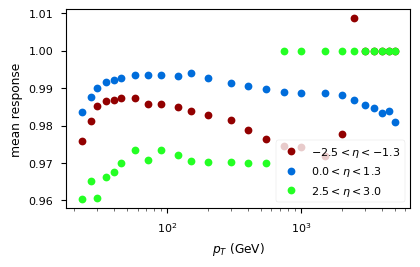

In [84]:

### To ignore the points with 0 on y axis when setting the y axis limits
mean_p = mean.copy()
mean_p[mean_p==0] = np.nan

# h = np.max(histo.values()[('QCD',)])
fig, ax = plt.subplots()
start = 17
k1 = 2
k2 = np.where(etabins<=0)[0][-1]
k3 = np.where(etabins<=2.5)[0][-1]
ax.plot(ptbins[start:],mean_p[start:,k1], 'o', label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
ax.plot(ptbins[start:],mean_p[start:,k2], 'o', label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')
ax.plot(ptbins[start:],mean_p[start:,k3], 'o', label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')
ax.set_xlabel(r'$p_T$ (GeV)');
ax.set_ylabel(r'mean response');
ax.set_xscale('log')
# ax.set_ylim([0.8,1.1])
ax.legend()
if test_run:
    plt.savefig('fig/corr_vs_pt'+samp+tag+'_test.png')
else:
    plt.savefig('fig/corr_vs_pt'+samp+tag+'.png')

plt.show();

### Fit a specific $\eta$ $p_T$ bin

In [80]:
p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])

In [78]:
histo = output['ptresponse'].integrate('jeteta', hist.Interval(-2.5, -1.3)).integrate('pt', hist.Interval(3000, 5000))

try:
    p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
    print("Fit succeeded, p = ", p)
except:
    print("Fit failed, p = ", p)


fgaus = gauss(f_xvals, *p)

histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))
yvals = histo.values()[('QCD',)]

median[i,k] = np.median(histvals)
mean[i,k] = p[1]
width[i,k] = p[2]
idx.append(i)

Fit succeeded, p =  [-3.32150570e-18  9.99999999e-01  1.00000000e+00]


/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


<AxesSubplot:xlabel='RECO / GEN response', ylabel='Counts'>

Text(3.8, 0.0, 'Mean 1.00')

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(3.8, 0.0, 'Median nan')

Text(3.8, 0.0, 'Width 1.00')

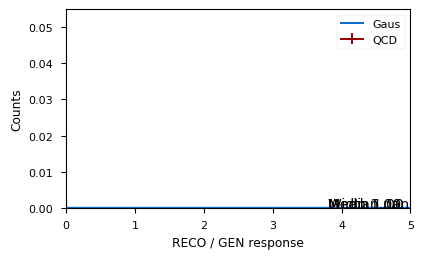

In [76]:
# %%capture
h = np.max(histo.values()[('QCD',)])
fig, ax2 = plt.subplots()
hist.plot1d(histo, ax=ax2, overlay='dataset')
ax2.plot(f_xvals, fgaus, label='Gaus')
plt.text(3.8,0.75*h,'Mean {0:0.2f}'.format(p[1]))
plt.text(3.8,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)))
plt.text(3.8,0.61*h,'Width {0:0.2f}'.format(p[2]))
ax2.legend()

# plt.show();
# plt.savefig('fig/ptResponse'+pt_string+eta_string+'.png');
# plt.close();

### Save fit data to csv's

In [144]:
etabins

array([-5. , -3. , -2.5, -1.3,  0. ,  1.3,  2.5,  3. ])

In [146]:
# data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data = {str(ptBin):mean[i] for i, ptBin in enumerate(ptbins)}

# data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data['etaBins'] = np.array([str(etaBin) for etaBin in etabins])

df = pd.DataFrame(data=data)
df = df.set_index('etaBins')
if test_run:
    df.to_csv('out_txt/EtaBinsvsPtBinsMean'+samp+tag+'.csv')
# else
#     df.to_csv('out_txt/EtaBinsvsPtBinsMean'+tag+'_test.csv')

In [147]:
# data_width = {str(ptBin):width[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data_width = {str(ptBin):width[i] for i, ptBin in enumerate(ptbins)}

# data_width['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data_width['etaBins'] = [str(etaBin) for etaBin in etabins]

df_width = pd.DataFrame(data=data_width)
df_width = df_width.set_index('etaBins')
if test_run:
    df_width.to_csv('out_txt/EtaBinsvsPtBinsWidth'+samp+tag+'.csv')
# else:
#     df_width.to_csv('out_txt/EtaBinsvsPtBinsWidth'+tag+'_test.csv')

In [145]:
len(data['etaBins'])
len(mean[0])

81

8

In [148]:
# data_median = {str(ptBin):median[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data_median = {str(ptBin):median[i] for i, ptBin in enumerate(ptbins)}

# data_median['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data_median['etaBins'] = [str(etaBin) for etaBin in etabins]

df_median = pd.DataFrame(data=data_median)
df_median = df_median.set_index('etaBins')
if test_run:
    df_median.to_csv('out_txt/EtaBinsvsPtBinsMedian'+samp+tag+'.csv')
# else:
#     df_median.to_csv('out_txt/EtaBinsvsPtBinsMedian'+tag+'_test.csv')

In [149]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)
    

         1.0  2.0       3.0      4.0       5.0       6.0       7.0       8.0  \
etaBins                                                                        
-5.0     1.0  1.0 -0.831762  0.70152  1.022921  1.027888  1.004245  1.025587   
-3.0     1.0  1.0  0.000000  0.00000  0.000000  0.000000 -3.323510 -0.056908   
-2.5     1.0  1.0  0.000000  0.00000  0.000000  0.000000  0.000000 -0.729886   
-1.3     1.0  1.0  0.000000  0.00000  0.000000 -2.092877  0.220531  0.544314   
0.0      1.0  1.0  0.000000  0.00000  0.000000 -1.168600  0.257954  0.554183   
1.3      1.0  1.0  0.000000  0.00000  0.000000  0.000000  0.000000 -1.047515   
2.5      1.0  1.0 -0.011199  0.00000  0.000000  0.000000 -0.715871 -0.356600   
3.0      0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   

              9.0      10.0      11.0      12.0      13.0      14.0      15.0  \
etaBins                                                                         
-5.0     1.024974  1.024248  1.019683

In [116]:
# # df[pt bin][eta bin]

# ptBin = '300'
# etaBin = '0.783'

# print('mean   =', np.round(df[ptBin][etaBin],3))
# print('median =', np.round(df_median[ptBin][etaBin],3))
# print('width  =', np.round(df_width[ptBin][etaBin],3))

In [118]:
# # df[pt bin][eta bin]

# ptBin = '300'
# etaBin = '0.783'

# print('mean   =', df[ptBin][etaBin])
# print('median =', df_median[ptBin][etaBin])
# print('width  =', df_width[ptBin][etaBin])

### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [ ]:
# df_csv = pd.read_csv('EtaBinsvsPtBinsMean.csv').set_index('etaBins')